# Amazon Food Reviews - KNN Implementation - by Shobhit Gupta

# 1) Introduction

In this notebook, we will be performing polarity prediction of of a given food review text by applying KNN (K- Nearest Neigbour) algorithm. Before building the prediction model, first step is to clean the data as a part of data-preprocessing.

We will perform following data preprocessing.

-- Removing Stop-words

-- Remove any punctuations or limited set of special characters.

-- Removing HTML tags

-- Stemming the word using Snowball Stemming

-- Converting the words to lowercase

#### Objective: Given a review, determine whether it is +ve or -ve using KNN -  algorithm and find the accuracy of the model

In [1]:
# ============================== loading libraries for KNN ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
# =============================================================================================

C:\Users\Shobhit\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# ======================== Loading libraries for pre-processing ====================================== #

%matplotlib inline

import sqlite3
import nltk
import string
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# ==================================================================================================== #

In [45]:
# using the SQLite Table to read data.
con = sqlite3.connect('C:/Users/Shobhit/Desktop/amazon-fine-food-reviews/database.sqlite')

filtered_data = pd.read_sql_query("""Select * from Reviews WHERE Score != 3""",con)

filtered_data.shape

(525814, 10)

# 2) Data pre-processing

In [4]:
# Assigning positive(4,5) and negative(1,2) to review Scores

def posneg(x):
    if x == 5 or x == 4:
        return "positive"
    return "negative"

actScore = filtered_data['Score']
pn = actScore.map(posneg)   #converting into 'positive' and 'negative'
filtered_data['Score'] = pn

In [5]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
final_pos = filtered_data[filtered_data['Score'] == 'positive']
final_pos = final_pos.sample(frac=0.035,random_state=1) #0.055

final_neg = filtered_data[filtered_data['Score'] == 'negative']
final_neg = final_neg.sample(frac=0.15,random_state=1) #0.25

final = pd.concat([final_pos,final_neg],axis=0)


final = final.sort_values('Time',axis=0,kind="quicksort", ascending=True).reset_index(drop=True)  #Sorting the data and resetting the index

In [8]:
final.shape

(27838, 10)

In [9]:
final['Score'].value_counts()   #Checking that dataset is not imbalanced

positive    15532
negative    12306
Name: Score, dtype: int64

In [10]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

2
Set in a small New England town, Tim Burton's masterpiece &quot;Beetlejuice&quot; follows the life of Adam and Barbara Maitlin, owners of a large house and small hardware store. While taking a vacation at home, the couple drowns in a mishap car accident. When their home is taken over by boisterous city-folk, they turn in several directions for help  in haunting the Deets family. One such prospective poltergeist is Beetlejuice- brilliantly played by Michael Keaton. <p>Featuring a star-studded cast including a young Winona Ryder, Geena Davis, Alec Baldwin and of course Keaton, the storyline boasts creative, believable characters simply not seen in movies these days. <p>Everything in the storyline is clever, from props to costumes right down the score. One of my absolute favorite films!


In [11]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)

{'that', 'i', 'further', 'such', "hasn't", "needn't", 'during', 'into', 'with', 'weren', 'd', 'isn', 'ma', 'themselves', 'a', 'of', 'can', 'hadn', 'any', 'mustn', 'other', "that'll", 'aren', 'has', 'theirs', 'too', 'you', 'herself', 'hers', 'how', 'me', 'the', 'here', 'no', 'him', 'should', 'from', 'we', 'which', 'yourselves', 'm', "isn't", 'once', 'his', 'after', 'some', "haven't", 'needn', "won't", 'is', 'before', 'whom', 'shan', "you're", 'o', 'off', "shan't", 'doing', "doesn't", 'in', 'against', 'he', 'out', "aren't", 'mightn', 'own', 'all', 'same', 'each', "wasn't", 'both', 'it', 'over', 'through', 'being', "weren't", 'ain', 'these', "you'd", 'having', 'above', "should've", 'between', 'my', 'then', 'very', 'her', 'about', 'myself', 'there', 'did', 're', 'itself', 'this', 'does', 's', 'had', 'wasn', 'were', 'what', "don't", 'now', 'why', 'was', 'or', 'yourself', 'under', 'at', "you've", 'our', 'she', 'don', 'ourselves', "she's", 'than', "mustn't", 'those', 'when', 'its', 'their', '

### -- Removing Stop-words

### -- Remove any punctuations or limited set of special characters.

### -- Removing HTML tags

### -- Stemming the word using Snowball Stemming

### -- Converting the words to lowercase

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

# 3) Implementing KNN with each method of vectorization

## 3.1) KNN with BOW 

In [13]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['Text'].values)

In [14]:
final_counts.shape

(27838, 32673)

In [15]:
#Splitting data into Train and test - 70% Train, 30 % test
import math

X = final_counts
y = final['Score']

X_train =  final_counts[:math.ceil(len(final)*.7)] 
X_test = final_counts[math.ceil(len(final)*.7):]
y_train = y[:math.ceil(len(final)*.7)]
y_test =  y[math.ceil(len(final)*.7):]

In [16]:
#Splitting Train and test data into Cross validation train and cross validation test (70 % CV train, 30 % CV test)

X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_train, y_train, test_size=0.3)

10 Fold Cross validation function

In [17]:
def find_optimal_k(X_train,y_train):
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

KNN with optimal K


The optimal number of neighbors is 15.


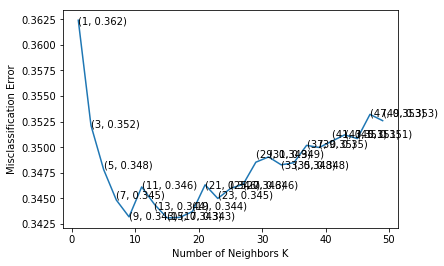

the misclassification error for each k value is :  [0.362 0.352 0.348 0.345 0.343 0.346 0.344 0.343 0.343 0.344 0.346 0.345
 0.346 0.346 0.349 0.349 0.348 0.348 0.35  0.35  0.351 0.351 0.351 0.353
 0.353]


In [18]:
optimal_k = find_optimal_k(X_train ,y_train)

In [19]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier using brute for k = 15 is 63.716920%


In [20]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier using kdtree for k = %d is %f%%' % (optimal_k, acc))

C:\Users\Shobhit\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



The accuracy of the knn classifier using kdtree for k = 15 is 63.716920%


## 3.2) KNN with TF-IDF

In [21]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)

In [22]:
final_tf_idf.shape

(27838, 530271)

In [23]:
#Splitting data into Train and test - 70% Train, 30 % test
import math

X_traintf =  final_tf_idf[:math.ceil(len(final)*.7)] 
X_testtf = final_tf_idf[math.ceil(len(final)*.7):]
y_traintf = y[:math.ceil(len(final)*.7)]
y_testtf =  y[math.ceil(len(final)*.7):]


The optimal number of neighbors is 37.


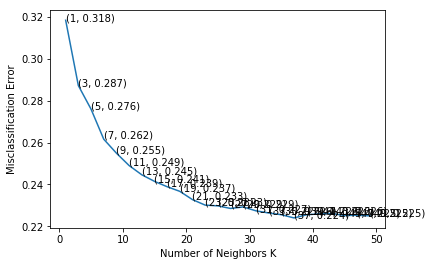

the misclassification error for each k value is :  [0.318 0.287 0.276 0.262 0.255 0.249 0.245 0.241 0.239 0.237 0.233 0.23
 0.23  0.229 0.229 0.227 0.226 0.226 0.224 0.226 0.226 0.226 0.225 0.225
 0.225]


In [24]:
optimal_k = find_optimal_k(X_traintf ,y_traintf)

In [25]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_traintf, y_traintf)

# predict the response
pred = knn_optimal.predict(X_testtf)

# evaluate accuracy
acc = accuracy_score(y_testtf, pred) * 100
print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier using brute for k = 37 is 78.170279%


In [26]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_traintf, y_traintf)

# predict the response
pred = knn_optimal.predict(X_testtf)

# evaluate accuracy
acc = accuracy_score(y_testtf, pred) * 100
print('\nThe accuracy of the knn classifier using kdtree for k = %d is %f%%' % (optimal_k, acc))

C:\Users\Shobhit\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



The accuracy of the knn classifier using kdtree for k = 37 is 78.170279%


## 3.3) KNN with Average Word2Vec

In [27]:
# Train your own Word2Vec model using your own text corpus
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

C:\Users\Shobhit\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [28]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [29]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [30]:
from sklearn.preprocessing import StandardScaler

final_w2v = StandardScaler().fit_transform(sent_vectors)

In [31]:
import math
X = final_w2v
y = final['Score']

X_trainw =  final_w2v[:math.ceil(len(final)*.7)]
X_testw = final_w2v[math.ceil(len(final)*.7):]
y_trainw = y[:math.ceil(len(final)*.7)]
y_testw =  y[math.ceil(len(final)*.7):]


The optimal number of neighbors is 33.


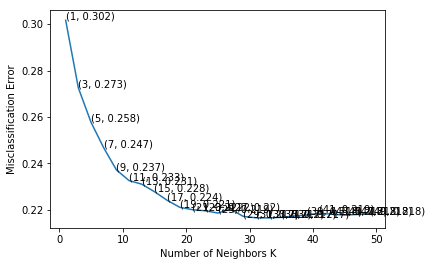

the misclassification error for each k value is :  [0.302 0.273 0.258 0.247 0.237 0.233 0.231 0.228 0.224 0.221 0.22  0.22
 0.219 0.22  0.217 0.217 0.217 0.217 0.217 0.218 0.219 0.218 0.218 0.218
 0.218]


In [32]:
optimal_k = find_optimal_k(X_trainw ,y_trainw)

In [33]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_trainw, y_trainw)

# predict the response
pred = knn_optimal.predict(X_testw)

# evaluate accuracy
acc = accuracy_score(y_testw, pred) * 100
print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier using brute for k = 33 is 78.206203%


In [34]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_trainw, y_trainw)

# predict the response
pred = knn_optimal.predict(X_testw)

# evaluate accuracy
acc = accuracy_score(y_testw, pred) * 100
print('\nThe accuracy of the knn classifier using kdtree for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier using kdtree for k = 33 is 78.206203%


## 3.4) KNN on TF-IDF Word2Vec

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [39]:
from sklearn.preprocessing import StandardScaler

final_tf_w2v = StandardScaler().fit_transform(tfidf_sent_vectors)

In [41]:
X = final_tf_w2v
y = final['Score']

X_traintw =  final_w2v[:math.ceil(len(final)*.7)]
X_testtw = final_w2v[math.ceil(len(final)*.7):]
y_traintw = y[:math.ceil(len(final)*.7)]
y_testtw =  y[math.ceil(len(final)*.7):]


The optimal number of neighbors is 33.


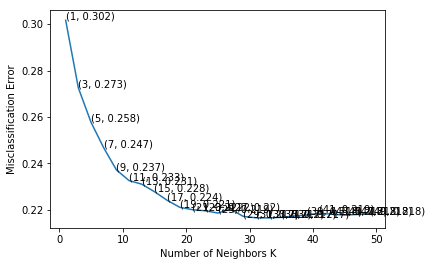

the misclassification error for each k value is :  [0.302 0.273 0.258 0.247 0.237 0.233 0.231 0.228 0.224 0.221 0.22  0.22
 0.219 0.22  0.217 0.217 0.217 0.217 0.217 0.218 0.219 0.218 0.218 0.218
 0.218]


In [42]:
optimal_k = find_optimal_k(X_traintw ,y_traintw)

In [43]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='brute')

# fitting the model
knn_optimal.fit(X_traintw, y_traintw)

# predict the response
pred = knn_optimal.predict(X_testtw)

# evaluate accuracy
acc = accuracy_score(y_testtw, pred) * 100
print('\nThe accuracy of the knn classifier using brute for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier using brute for k = 33 is 78.206203%


In [44]:
# ============================== KNN with k = optimal_k ===============================================
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm='kd_tree')

# fitting the model
knn_optimal.fit(X_traintw, y_traintw)

# predict the response
pred = knn_optimal.predict(X_testtw)

# evaluate accuracy
acc = accuracy_score(y_testtw, pred) * 100
print('\nThe accuracy of the knn classifier using kdtree for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier using kdtree for k = 33 is 78.206203%


#### Conclusion(s):
#### - K-NN Algorithm predicts the class label of reviews given as test data to it.
#### - In different methods of vectorization, the model's accuracy differs.
#### - Using 'brute force' or 'kdtree' as algorithm method makes hardly any difference in accuracy value (in the same method of vectorization).
#### - Word2Vec (Avg & TF-IDF) method is observed to have the maximum accuracy ~ 78% . This means that 78% of the test data fed to the model is labelled correctly